In [94]:
''''
This workflow is divided in two parts
First pass is to map the country with its corresponding IP code. I used np.searchsorted to do this, and there were some 
nans values that got remove.

The next step is to perform feature engineering. Signup time was scaled down to monthly unit (1-12), and purchase time 
was scaled down to hour unit (1-24). Encoder was applied to transform categorical data to numerical data.

Even though Random Forest Model is not sensitive to normalizations of features, the MinMaxScaler() was applied to normalize
the data

8 features used: ['country','source','sex','signup_time','purchase_time','purchase_value','age','ip_address']

The dataset is imbalanced so undersampling method was used in negative class (0) with 2x sampling rate to 
train the RF model.

Model was crossvalidated with k-fold = 4 using GridSearchCV and tested against all data.

Performance is reasonable with f-1 score about 0.6 in positive class and 0.96 in negative class. 

In this problem the false negatives are dangerous because the model would miss fraudulent acitivies. The false positives
are less concernable in this particular problem, they can be considered as false alarmed.


Characteristics of positive class: slightly younger population, more male , and usually coming from USA, China, Japan, South Korean, and UK. Please see plots.

'''




"'\nThis workflow is divided in two parts\nFirst pass is to map the country with its corresponding IP code. I used np.searchsorted to do this, and there were some \nnans values that got remove.\n\nThe next step is to perform feature engineering. Signup time was scaled down to monthly unit (1-12), and purchase time \nwas scaled down to hour unit (1-24). Encoder was applied to transform categorical data to numerical data.\n\nEven though Random Forest Model is not sensitive to normalizations of features, the MinMaxScaler() was applied to normalize\nthe data\n\n8 features used: ['country','source','sex','signup_time','purchase_time','purchase_value','age','ip_address']\n\nThe dataset is imbalanced so undersampling method was used in negative class (0) with 2x sampling rate to \ntrain the RF model.\n\nModel was crossvalidated with k-fold = 4 using GridSearchCV and tested against all data.\n\nPerformance is reasonable with f-1 score about 0.6 in positive class and 0.96 in negative class. \n\

In [0]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import os
from sklearn.cluster import KMeans
import bisect

import urllib
import requests
import json
sns.set()

In [37]:
fraud_data = pd.read_csv('Fraud_Data.csv')
fraud_data.sort_values('ip_address', inplace =True)
fraud_data.head(10)

user_id          signup_time        purchase_time  purchase_value  \
110447    62421  2015-02-16 00:17:05  2015-03-08 10:00:39              46   
2589     173212  2015-03-08 04:03:22  2015-03-20 17:23:45              33   
16752    242286  2015-05-17 16:45:54  2015-05-26 08:54:34              33   
51261    370003  2015-03-03 19:58:39  2015-05-28 21:09:13              33   
17       119824  2015-03-20 00:31:27  2015-04-05 07:31:46              55   
15992    266190  2015-06-18 00:38:29  2015-06-27 04:35:25              21   
27057    241175  2015-07-17 11:31:56  2015-08-14 22:21:41              87   
38854    138971  2015-07-11 05:31:15  2015-08-04 04:43:58              21   
149591   377916  2015-02-21 02:25:55  2015-03-21 09:09:10              60   
11263     21325  2015-05-12 02:33:40  2015-05-20 20:15:35              35   

            device_id  source  browser sex  age     ip_address  class  
110447  ZCLZTAJPCRAQX  Direct   Safari   M   36   52093.496895      0  
2589    YFGYOALADBHLT     Ads       IE   F   30   93447.138961      0  
16752   QZNVQTUITFTHH  Direct  FireFox   F   32  105818.501505      0  
51261   PIBUQMBIELMMG     Ads       IE   M   40  117566.664867      0  
17      WFIIFCPIOGMHT     Ads   Safari   M   38  131423.789042      0  
15992   NSJYRZTYTCMFV     SEO   Chrome   M   32  155130.397004      0  
27057   QXEAKJVUIOMJT     SEO   Chrome   M   33  155399.107925      0  
38854   AMZQWDRAWLNCE     SEO   Chrome   M   24  159119.791297      0  
149591  HTQECMMGBKUSC     Ads       IE   M   37  166326.775242      0  
11263   FYNYUCGEWCKGR     Ads       IE   M   25  207999.643852      0

In [38]:
ip_df  = pd.read_csv('IpAddress_to_Country.csv')
ip_df.sort_values('lower_bound_ip_address',inplace =True)
ip_df['index'] = ip_df.index
ip_df.head(5)

lower_bound_ip_address  upper_bound_ip_address    country  index
0              16777216.0                16777471  Australia      0
1              16777472.0                16777727      China      1
2              16777728.0                16778239      China      2
3              16778240.0                16779263  Australia      3
4              16779264.0                16781311      China      4

In [0]:
# ip_df['range'] = ip_df['upper_bound_ip_address']-ip_df['lower_bound_ip_address']
# ip_df['range'].describe()

In [0]:
# ip_df[ip_df['country']=='Australia']['lower_bound_ip_address'].hist()
# ip_df[ip_df['country']=='Singapore']['lower_bound_ip_address'].hist()

In [41]:
# every lower_bound is unique, no overlapped 
ip_df['lower_bound_ip_address'].nunique()

138846

In [42]:
ip_range = np.array(ip_df[['lower_bound_ip_address','upper_bound_ip_address']])
ip_range


array([[1.67772160e+07, 1.67774710e+07],
       [1.67774720e+07, 1.67777270e+07],
       [1.67777280e+07, 1.67782390e+07],
       ...,
       [3.75809536e+09, 3.75809587e+09],
       [3.75809587e+09, 3.75809613e+09],
       [3.75809613e+09, 3.75809638e+09]])

In [43]:
ip_address = np.array(fraud_data['ip_address'])
ip_address

array([5.20934969e+04, 9.34471390e+04, 1.05818502e+05, ...,
       4.29471953e+09, 4.29482224e+09, 4.29485050e+09])

In [44]:
ip_range.ravel()

array([1.67772160e+07, 1.67774710e+07, 1.67774720e+07, ...,
       3.75809613e+09, 3.75809613e+09, 3.75809638e+09])

In [45]:
index = np.searchsorted(ip_range.ravel(),ip_address, side = 'left' )
index

array([     0,      0,      0, ..., 277692, 277692, 277692])

In [0]:
fraud_data['index_searchsorted'] =  np.divide(index - 1,2)

In [47]:
fraud_data.head()

user_id          signup_time        purchase_time  purchase_value  \
110447    62421  2015-02-16 00:17:05  2015-03-08 10:00:39              46   
2589     173212  2015-03-08 04:03:22  2015-03-20 17:23:45              33   
16752    242286  2015-05-17 16:45:54  2015-05-26 08:54:34              33   
51261    370003  2015-03-03 19:58:39  2015-05-28 21:09:13              33   
17       119824  2015-03-20 00:31:27  2015-04-05 07:31:46              55   

            device_id  source  browser sex  age     ip_address  class  \
110447  ZCLZTAJPCRAQX  Direct   Safari   M   36   52093.496895      0   
2589    YFGYOALADBHLT     Ads       IE   F   30   93447.138961      0   
16752   QZNVQTUITFTHH  Direct  FireFox   F   32  105818.501505      0   
51261   PIBUQMBIELMMG     Ads       IE   M   40  117566.664867      0   
17      WFIIFCPIOGMHT     Ads   Safari   M   38  131423.789042      0   

        index_searchsorted  
110447                -0.5  
2589                  -0.5  
16752                 -0.5  
51261                 -0.5  
17                    -0.5

In [0]:
master = pd.merge(ip_df,fraud_data,left_on = 'index', right_on = 'index_searchsorted', how = 'inner')

In [49]:
# check to see if the data is mapping correctly
test = (master['lower_bound_ip_address']< master['ip_address']) & (master['ip_address']<master['upper_bound_ip_address'])
test.describe()

count     129146
unique         1
top         True
freq      129146
dtype: object

In [50]:
master.head()

lower_bound_ip_address  upper_bound_ip_address    country index  user_id  \
0              16778240.0                16779263  Australia     3   247547   
1              16809984.0                16842751   Thailand     8   220737   
2              16843264.0                16843775      China    11   390400   
3              16924672.0                16941055      China    30    69592   
4              16941056.0                16973823   Thailand    31   174987   

           signup_time        purchase_time  purchase_value      device_id  \
0  2015-06-28 03:00:34  2015-08-09 03:57:29              47  KIXYSVCHIPQBR   
1  2015-01-28 14:21:11  2015-02-11 20:28:28              15  PKYOWQKWGJNJI   
2  2015-03-19 20:49:09  2015-04-11 23:41:23              44  LVCSXLISZHVUO   
3  2015-02-24 06:11:57  2015-05-23 16:40:14              55  UHAUHNXXUADJE   
4  2015-07-07 12:58:11  2015-11-03 04:04:30              51  XPGPMOHIDRMGE   

   source browser sex  age    ip_address  class  index_searchsorted  
0     SEO  Safari   F   30  1.677886e+07      0                 3.0  
1     SEO  Chrome   F   34  1.684205e+07      0                 8.0  
2     Ads      IE   M   29  1.684366e+07      0                11.0  
3  Direct  Chrome   F   30  1.693873e+07      0                30.0  
4     SEO  Chrome   F   37  1.697198e+07      0                31.0

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


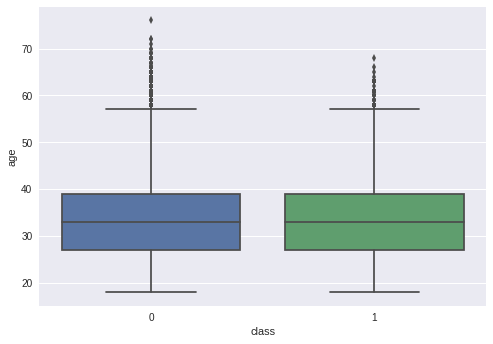

In [69]:
sns.boxplot(x="class", y="age", data=master)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


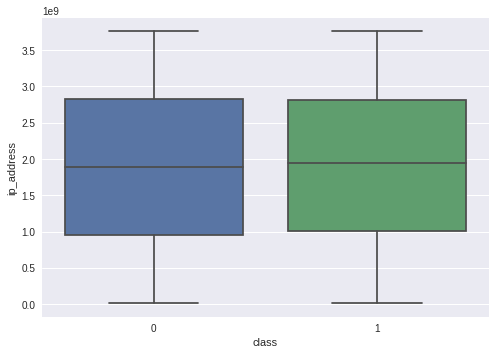

In [72]:
sns.boxplot(x="class", y="ip_address", data=master)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


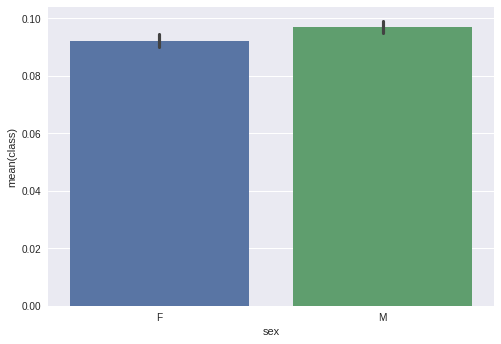

In [73]:
sns.barplot(x="sex", y="class", data=master)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
No handles with labels found to put in legend.


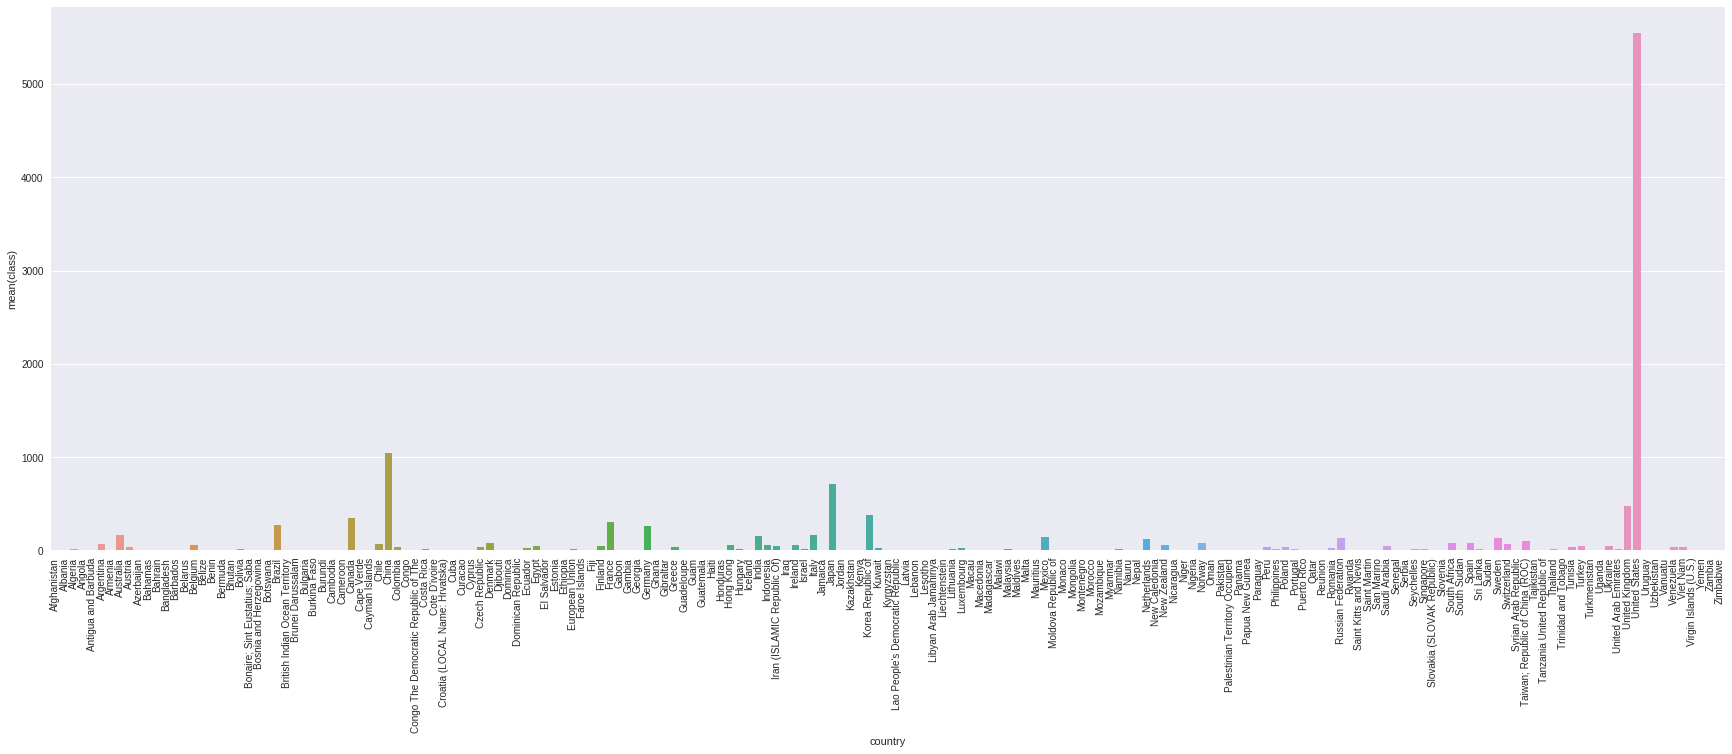

In [88]:
plt.figure(figsize = (30,10))

country = pd.DataFrame(master.groupby('country')['class'].sum())

sns.barplot(x=country.index, y = 'class', data=country)
plt.xticks(rotation=90)
plt.legend()


In [0]:
# inspect to see which country has the most fradulent activities
#master.groupby('country')['class'].sum().sort_values()

In [0]:
#preparing data for RF model

master.dropna(inplace = True) # removing nans in master

np.random.seed(5)
sampling_rate = 2
number_postiveclass = len(master[master['class']==1])

master_negativeclass = master[master['class'] != 1].sample(number_postiveclass*sampling_rate)
master_positveclass = master[master['class'] == 1]

master_train = pd.concat([master_negativeclass,master_positveclass], axis = 0)

In [0]:
X1 =master_train[['country','source','sex']]
X = master_train[['signup_time','purchase_time','purchase_value','age','ip_address']]
#X = master_train[['signup_time','purchase_time','purchase_value','age']]
Y = master_train[['class']]

In [0]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import random

In [56]:
encode = preprocessing.LabelEncoder()

X_2 = X1.apply(encode.fit_transform)
X_2.head()

country  source  sex
111832      147       1    0
69499        30       2    0
95454        73       0    0
113461       28       1    0
46921       147       2    1

In [0]:
X = pd.concat([X,X_2], axis=1)



In [0]:
X['signup_time'] = pd.to_datetime(X['signup_time'])
X['purchase_time'] = pd.to_datetime(X['purchase_time'])

In [0]:
#scale signup time to month, and scale purchase_time to hour 
X['signup_time'] = X['signup_time'].dt.month
X['purchase_time'] = X['purchase_time'].dt.hour

In [60]:
scaler = MinMaxScaler()

X = scaler.fit_transform(X)

X

array([[0.57142857, 0.13043478, 0.40458015, ..., 0.9483871 , 0.5       ,
        0.        ],
       [0.85714286, 0.08695652, 0.35877863, ..., 0.19354839, 1.        ,
        0.        ],
       [0.85714286, 0.69565217, 0.28244275, ..., 0.47096774, 0.        ,
        0.        ],
       ...,
       [0.        , 0.86956522, 0.21374046, ..., 0.19354839, 0.        ,
        1.        ],
       [0.28571429, 0.82608696, 0.3740458 , ..., 0.19354839, 0.        ,
        1.        ],
       [0.71428571, 0.65217391, 0.15267176, ..., 0.19354839, 1.        ,
        0.        ]])

In [0]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=100)

In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [10,20,50],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2,5,10],
    'n_estimators': [10,50,100]
}

rf = RandomForestClassifier()

model = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 1)

model.fit(X_train,y_train)



Fitting 4 folds for each of 81 candidates, totalling 324 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [10, 20, 50], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [2, 5, 10], 'n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [63]:
best_model = model.best_estimator_


y_predict = best_model.predict(X_test)

print(confusion_matrix(y_test,y_predict))

print(classification_report(y_test, y_predict))

[[2356  100]
 [ 546  679]]
             precision    recall  f1-score   support

          0       0.81      0.96      0.88      2456
          1       0.87      0.55      0.68      1225

avg / total       0.83      0.82      0.81      3681



In [64]:
#take the best model and give prediction on large scale
X1_big =master[['country','source','sex']]
X_big = master[['signup_time','purchase_time','purchase_value','age','ip_address']]
#X_big = master[['purchase_value','age','ip_address']]
Y_big = master[['class']]
X_2_big = X1_big.apply(encode.fit_transform)
X_big = pd.concat([X_big,X_2_big], axis=1)
X_big['signup_time'] = pd.to_datetime(X_big['signup_time'])
X_big['purchase_time'] = pd.to_datetime(X_big['purchase_time'])
#scale signup time to month, and scale purchase_time to hour 
X_big['signup_time'] = X_big['signup_time'].dt.month
X_big['purchase_time'] = X_big['purchase_time'].dt.hour
X_big = scaler.transform(X_big)


Y_big_predict = best_model.predict(X_big)

print(confusion_matrix(Y_big,Y_big_predict))

print(classification_report(Y_big,Y_big_predict))

[[113160   3718]
 [  5046   7222]]
             precision    recall  f1-score   support

          0       0.96      0.97      0.96    116878
          1       0.66      0.59      0.62     12268

avg / total       0.93      0.93      0.93    129146

